<a href="https://colab.research.google.com/github/DmitryKostin/tinkoff-industry-data-analysis/blob/main/06_tinkoff_module_project_2/tinkoff_module_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ данных в индустрии. Проект 2

**Содержание** <a class='anchor' id='table_of_contents'></a>

- [**Задание 1**](#task_1)
    - [Контекст](#step_1_1)
    - [Метрики и альтернатива в критерии](#step_1_2)
    - [Определение размера выборки](#step_1_3)
    - [Получение выборки от бота](#step_1_4)
    - [Принятие решения о тесте](#step_1_5)
- [**Задание 2**](#task_2)
    - [Контекст](#step_2_1)
    - [Метрики и альтернатива в критерии](#step_2_2)
    - [Выбор параметра для проверки однородности](#step_2_3)
    - [Определение размера выборки](#step_2_4)
    - [Получение выборки от бота](#step_2_5)
    - [Анализ контрольных и прокси метрик](#step_2_6)
    - [Проверка параметра на однородность](#step_2_7)
    - [Применение критерия](#step_2_8)

## `chat_id` из Телеграма:

In [ ]:
chat_id = 944932368

# Задание 1 <a class='anchor' id='task_1'></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import mannwhitneyu, ks_2samp, probplot, norm, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Контекст <a class='anchor' id='step_1_1'></a>

Мы считаем, что наш продукт достаточно дорогой для клиента.
У нас есть гипотеза, что уменьшение цены продукта
позволит повысить частоту продаж
и суммарно увеличит доходность продукта.
        
**Тест**

Мы проводим тест,
в рамках которого контролем является
продажа продукта со старой ценой,
а тестом - продажа продукта с новой ценой.
Целью этого теста
является проверка гипотезы роста доходности
нашего продукта из-за уменьшения тарифа.

**Статистические вводные**

Уровень значимости 5%.
Мы хотели бы различать 5%-ное
изменение целевой метрики
с вероятностью 80%.

In [ ]:
data = pd.read_csv('hist_telesales.csv')

Описание колонок в исторических данных.

- `ID` - номер задания на звонок
- `Флаг дозвона` - 1 если в рамках задания мы дозвонились человеку, иначе 0
- `Флаг продажи` - 1 если в рамках задания мы продали наш продукт человеку, иначе 0
- `Расходы` - сумма затрат на задание
- `PV` - 0 если мы не продали наш продукт, иначе = PV проданного продукта
- `NPV` = PV - Расходы

In [ ]:
data.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,0,90,0,-90
1,1,0,0,5,0,-5
2,2,0,0,68,0,-68
3,3,1,0,22,0,-22
4,4,1,0,22,0,-22


## Метрики и альтернатива в критерии <a class='anchor' id='step_1_2'></a>

Определим целевую, контрольные и прокси метрики.

### Целевая метрика

<p>Для проверки статистически значимых различий между NPV групп (целевая метрика) введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Среднее значение NPV в тестовой и контрольной группах не различается}\\
   H_1 :\text{Среднее значение NPV в тестовой группе больше, чем среднее значение NPV в контрольной группе}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

### Контрольная метрика

- конверсия из заявки в продажу;
- кумулятивная конверсия;
- относительное изменение кумулятивной конверсии тестовой группы к контрольной;

Во время тестирования нам необходимо следить, чтобы конверсия, которую мы выбрали в качестве контрольной метрики, не упала в тестовой группе ниже базового уровня в 30% к окончанию тестирования.

### Прокси метрики

- кумулятивное NPV;
- кумулятивное среднее NPV;
- относительное изменение кумулятивного NPV тестовой группы к контрольной.

## Определение размера выборки <a class='anchor' id='step_1_3'></a>

Целевая метрика имеет небинарное распределение и мы хотим проверить одностороннюю альтернативу. В этом случае минимальный размер выборки будет вычисляться по следующей формуле:

$$n = m = \frac{2\sigma^2(z_{1-\alpha} - z_\beta)^2}{d^2}$$

где $n, m$ - размеры выборок тестовой и контрольной группы;

$\sigma^2$ - выборочная дисперсия целевой метрики на исторических данных;

$\alpha$ - уровень значимости, допустимая вероятность ошибки I рода;

$\beta$ - допустимая вероятность ошибки II рода;

$z_{1-\alpha}$ - значение квантиля стандартного нормального распределения для $\alpha$;

$z_\beta$ - значение квантиля стандартного нормального распределения для $\beta$;

$d$ - uplift * среднее значение метрики NPV на исторических данных.

In [ ]:
alpha = 0.05
beta = 0.2
uplift = 0.05
variance = data['NPV'].var()
d = data['NPV'].mean() * uplift

sample_size = (2 * variance * (norm.ppf(1.0 - alpha) - norm.ppf(beta)) ** 2) / (d ** 2)
print('Размер выборки:', round(sample_size))

Размер выборки: 28672


Получаем минимальный размер выборки - 28 672 заявки.

## Получение выборки от бота <a class='anchor' id='step_1_4'></a>

In [ ]:
sample_id = 2780

In [ ]:
control = pd.read_csv('Контроль.csv')

In [ ]:
test = pd.read_csv('Тест.csv')

## Принятие решения о тесте <a class='anchor' id='step_1_5'></a>

Рассчитаем для тестовой и контрольной группы следующие метрики:
- `cum_NPV` - кумулятивное NPV;
- `cum_average_NPV` - кумулятивное среднее NPV;
- `cum_sale_flag` - сумма успешных продаж с накоплением;
- `cum_conversion` - кумулятивная конверсия из заявки в продажу.

In [ ]:
test['cum_NPV'] = test['NPV'].cumsum()
test['cum_average_NPV'] = test['NPV'].expanding(min_periods=1).mean()
test['cum_sale_flag'] = test['Флаг продажи'].cumsum()
test['cum_conversion'] = test['cum_sale_flag'] / len(test)

In [ ]:
control['cum_NPV'] = control['NPV'].cumsum()
control['cum_average_NPV'] = control['NPV'].expanding(min_periods=1).mean()
control['cum_sale_flag'] = control['Флаг продажи'].cumsum()
control['cum_conversion'] = control['cum_sale_flag'] / len(control)

Создадим сводный датафрейм `mergedCumulativeData`, в котором объединим все рассчитанные метрики, разделяя их с помощью суффиксов `_control` и `_test` для соответствующей группы.

In [ ]:
mergedCumulativeData = (control[['ID', 
                                'cum_NPV', 
                                'cum_average_NPV', 
                                'cum_conversion']]
                        .merge(test[['ID', 
                                     'cum_NPV', 
                                     'cum_average_NPV', 
                                     'cum_conversion']],
                               left_on='ID', 
                               right_on='ID',
                               how='left', 
                               suffixes=['_control', '_test']))

In [ ]:
mergedCumulativeData.head()

,ID,cum_NPV_control,cum_average_NPV_control,cum_conversion_control,cum_NPV_test,cum_average_NPV_test,cum_conversion_test
0,0,-213,-213.00,0.0,-27,-27.000000,0.000000
1,1,-236,-118.00,0.0,2929,1464.500000,0.000035
2,2,-333,-111.00,0.0,4286,1428.666667,0.000070
3,3,-387,-96.75,0.0,4925,1231.250000,0.000105
4,4,-577,-115.40,0.0,4909,981.800000,0.000105


Объявим две вспомогательные функции для отрисовки графиков:
- `relative_plot()` - для отображения графика с относительными изменениями метрик;
- `cumulative_plot()` - для отображения графика с кумулятивными метриками;
- `dist_plot()` - для отображения распределений метрик тестовой и контрольной группы.

Функции будут принимать в качестве аргументов необходимые названия метрик.

In [ ]:
def relative_plot(test_metric, 
                  control_metric,
                  title,
                  y1, y2):
    plt.figure(figsize=(12, 6))
    plt.plot(mergedCumulativeData['ID'], mergedCumulativeData[test_metric]/mergedCumulativeData[control_metric]-1)
    plt.gca().grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.gca().grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
    plt.gca().minorticks_on()
    plt.title(title)
    plt.ylabel('Процентное отличие тестовой группы от контрольной')
    plt.xlabel('Заявки')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.ylim(y1, y2);

In [ ]:
def cumulative_plot(metric,
                    metric_title,
                    ticks_format=True):
    
    plt.figure(figsize=(12, 7))
    plt.plot(test['ID'], test[metric], label='Тестовая группа')
    plt.plot(control['ID'], control[metric], label='Контрольная группа')

    current_values = plt.gca().get_yticks()
    if ticks_format:
        plt.gca().set_yticklabels([format(int(x), ',').replace(',', ' ') for x in current_values])
    plt.gca().grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.gca().grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
    plt.gca().minorticks_on()
    plt.title(metric_title + ' тестовой и контрольной группы')
    plt.ylabel(metric_title)
    plt.xlabel('Заявки')
    plt.legend()
    plt.show();

In [ ]:
def dist_plot(metric, n=100, lim=False):
    
    fig = plt.figure(figsize=(12, 9))

    ax1 = plt.subplot(2, 2, 1)
    ax1.hist(control[metric], bins=n)
    ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
    if lim:
        plt.xlim(-1000, 3000)
    plt.title('Контрольная группа')
    plt.xlabel(metric)

    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    ax2.hist(test[metric], bins=n)
    ax2.grid(which='major', color='#DDDDDD', linewidth=0.8)
    if lim:
        plt.xlim(-1000, 3000)
    plt.xlabel(metric)

    fig.suptitle('Распределение метрики: ' + metric, 
                 verticalalignment='baseline', 
                 y=0.97, fontsize=14)
    plt.tight_layout()
    plt.title('Тестовая группа')
    plt.show();

Посмотрим, как тестирование повлияло на контрольные и прокси метрики.

Построим график кумулятивного NPV, которое мы выбрали в качестве прокси метрики. Будем считать, что процесс выполнения заявок равномерно распределен во времени.

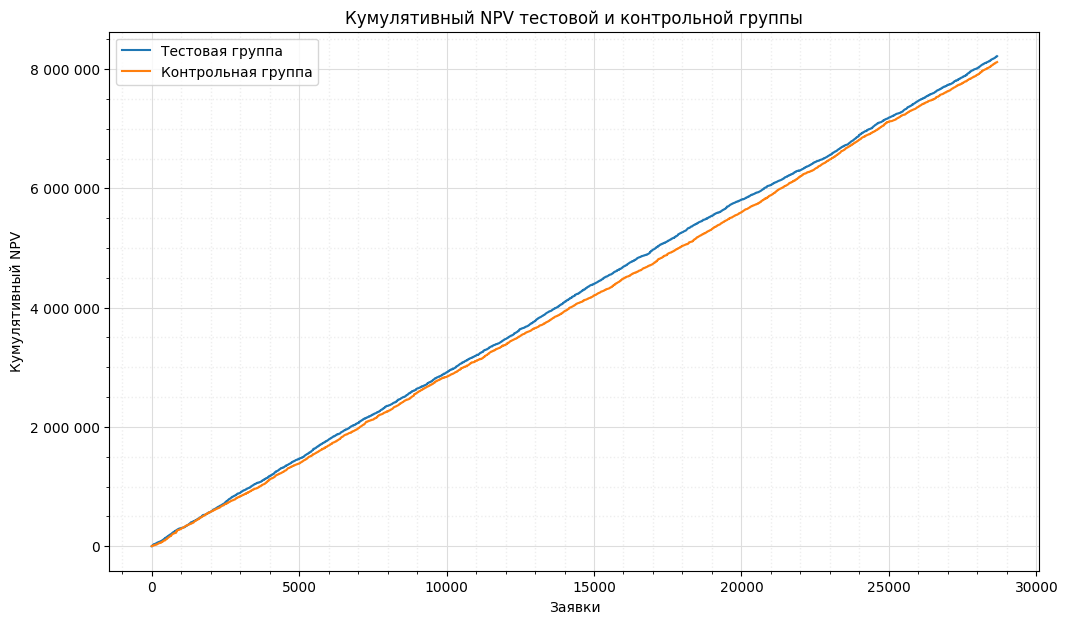

In [ ]:
cumulative_plot('cum_NPV',
                'Кумулятивный NPV')

Как мы видим, тестовая группа продемонстрировала более высокий уровень кумулятивного NPV в середине теста, что могло бы косвенно указывать на значимые различия в группах.

Рассмотрим график кумулятивного среднего NPV, которую мы также выбрали в качестве прокси метрики.

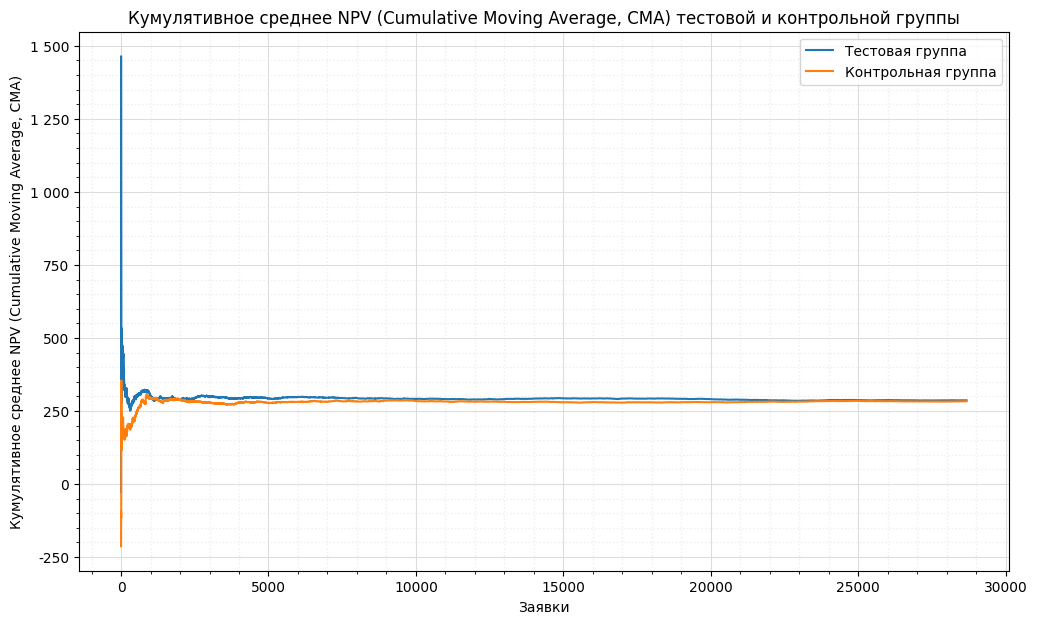

In [ ]:
cumulative_plot('cum_average_NPV',
                'Кумулятивное среднее NPV (Cumulative Moving Average, CMA)')

Как мы видим, тестовая группа также продемонстрировала схожий уровень кумулятивного среднего NPV на протяжении большей части теста.

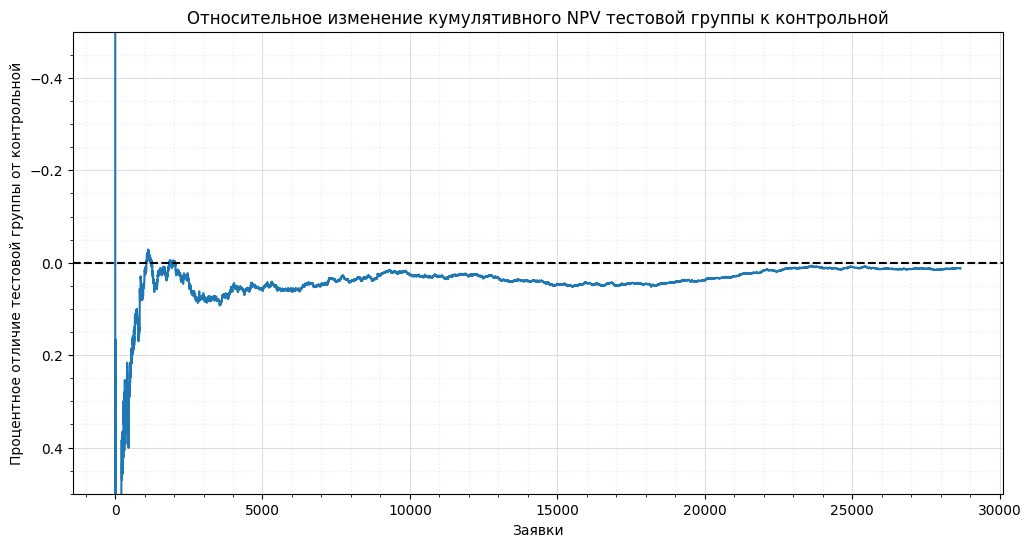

In [ ]:
relative_plot('cum_NPV_test', 
              'cum_NPV_control', 
              'Относительное изменение кумулятивного NPV тестовой группы к контрольной',
              0.5, -0.5)

На протяжении большей части тестирования значения кумулятивного NPV тестовой группы были меньше в среднем на 0.05%, чем у контрольной группы.

Рассмотрим график кумулятивной конверсии, которую мы выбрали в качестве контрольной метрики.

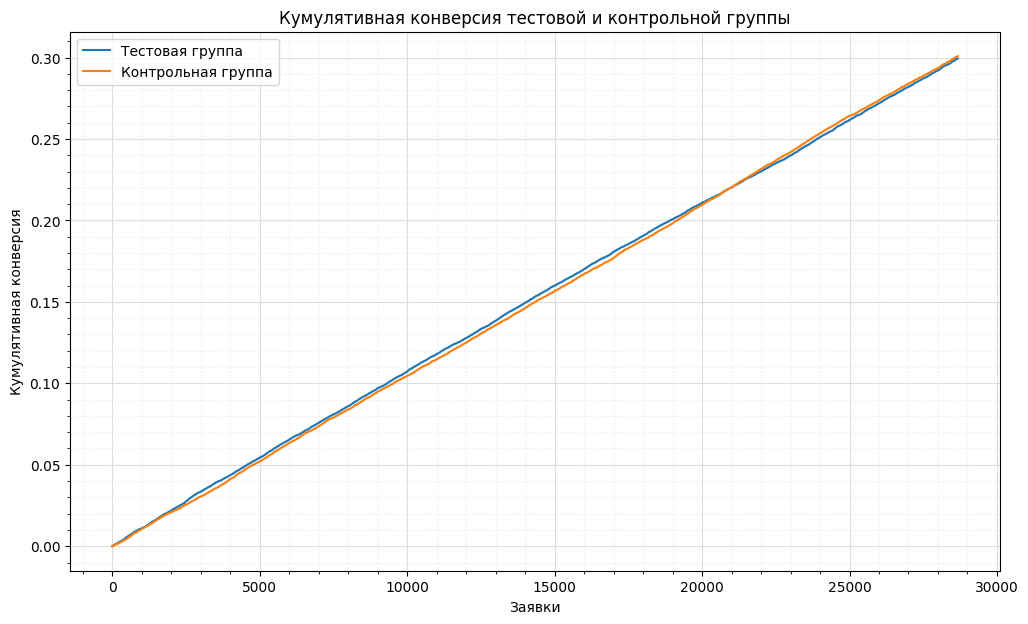

In [ ]:
cumulative_plot('cum_conversion', 
                'Кумулятивная конверсия', 
                ticks_format=False)

Мы видим, что на протяжении всего тестирования кумулятивная конверсия тестовой группы была на том же уровне, что и контрольная группа.

Рассмотрим динамику относительного изменения кумулятивной конверсии тестовой группы к контрольной.

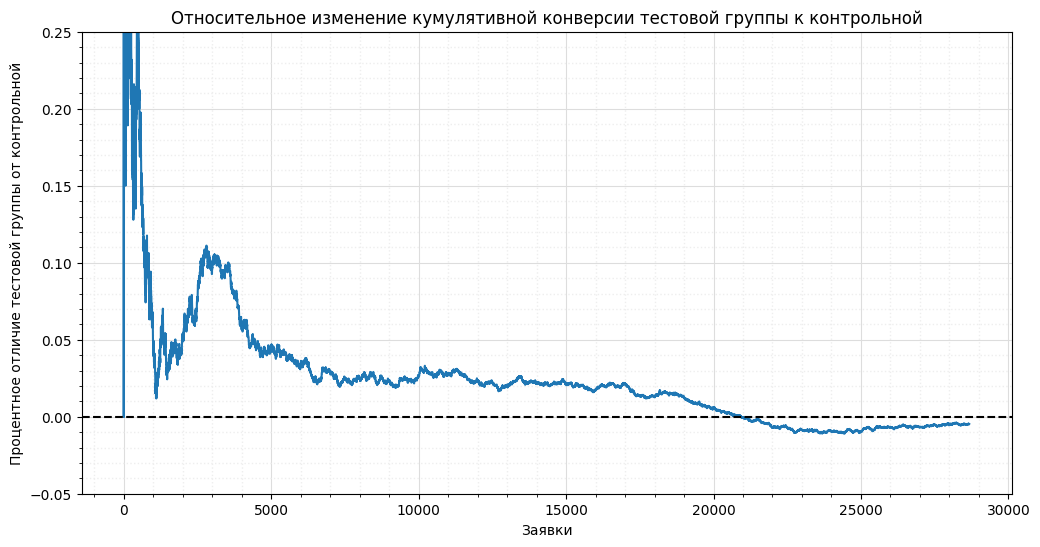

In [ ]:
relative_plot('cum_conversion_test', 
              'cum_conversion_control', 
              'Относительное изменение кумулятивной конверсии тестовой группы к контрольной',
              -0.05, 0.25)

Здесь мы также можем заметить, что подавляющую часть тестирования кумулятивная конверсия тестовой группы была выше в среднем на 0.03%, чем у контрольной группы. Тестирование завершилось с отставанием тестовой группы от контрольной на 0.01%.

Далее, необходимо установить, имеют ли обнаруженные различия в метриках статистическую значимость. Прежде чем выбрать для этого статистический критерий, посмотрим на распределения целевой метрики NPV.

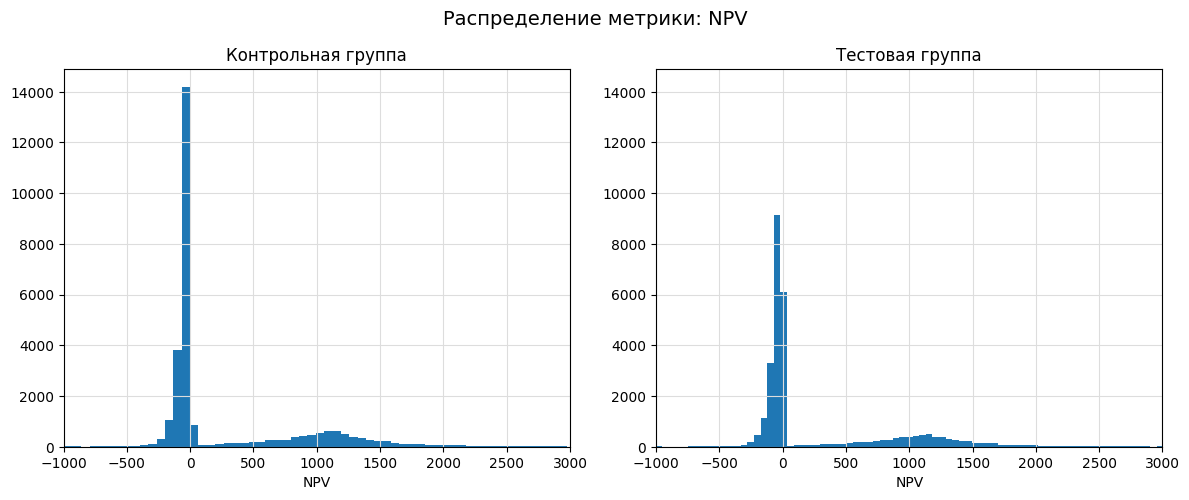

In [ ]:
dist_plot('NPV', n=350, lim=True)

Распределения выборок не похожи на нормальное распределение. В тестовой группе заметно меньшее количество нулевых и отрицательных значений NPV, что косвенно указывает на наличие видимых различий.

Воспользуемся критерием Стьюдента для сравнения различий между NPV тестовой и контрольной группы. 

<p>Для проверки статистически значимых различий между NPV групп (целевая метрика) введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Среднее значение NPV в тестовой и контрольной группах не различается}\\
   H_1 :\text{Среднее значение NPV в тестовой группе больше, чем среднее значение NPV в контрольной группе}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [ ]:
stat, p_value = ttest_ind(test['NPV'], control['NPV'], alternative='greater')

print('Процентное различие между средними выборок:',
    '{0:.3f}'.format(
    test['NPV'].mean()/control['NPV'].mean()-1))

print('p-value: ', '{:.4}'.format(p_value))

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными')

Процентное различие между средними выборок: 0.012
p-value:  0.2681
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными


Между средними выборок наблюдается различие в размере 1.2%, однако, данное различие не имеет статистической значимости. Полученное p-value составляет 0.2681, что больше уровня значимости 0.05. У нас недостаточно оснований, чтобы отклонить нулевую гипотезу. Процентное различие между средними выборок в размере 1.2% могло быть получено случайно с вероятностью 26.81%.

Поскольку мы не обнаружили статистической значимости в целевой метрике, рассмотрим различия в конверсии, которая выступает в роли контрольной метрики. Проведем Z-test Фишера.

<p>Для проверки статистически значимых различий между конверсией групп (контрольная метрика) введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Доли продаж в тестовой и контрольной группе не различаются}\\
   H_1 :\text{Доля продаж в тестовой группе больше, чем доля продаж в контрольной группе}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [ ]:
successes = np.array([test['Флаг продажи'].sum(), control['Флаг продажи'].sum()])
trials = np.array([len(test), len(control)])

stat, pval = proportions_ztest(successes, trials, alternative='larger')

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

print('p-value: ', '{:.4}'.format(pval))
print(f'Доля тестовой группы: {"{:.2%}".format(p1)}')
print(f'Доля контрольной группы: {"{:.2%}".format(p2)}')
print('Разница:', "{:.2%}".format(p1 - p2))

if pval < 0.05:
    print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными')

p-value:  0.6456
Доля тестовой группы: 29.94%
Доля контрольной группы: 30.08%
Разница: -0.14%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными


Поскольку мы оказались в ситуации множественной проверки гипотез, необходимо скорректировать значение уровня значимости для каждой проверки - сделаем это с помощью метода Холма. Реализовать данный метод можно при помощи функции $multipletests()$ из библиотеки $statsmodels$ с параметром `method='holm'`. 

Число гипотез - 2, начальный уровень значимости 0.05.

In [ ]:
_, p_value_1 = mannwhitneyu(test['NPV'], control['NPV'], alternative='greater')
_, p_value_2 = proportions_ztest(successes, trials, alternative='larger')

print(sorted([p_value_1, p_value_2]))

print("FWER: " + str(multipletests(sorted([p_value_1, p_value_2]), alpha=0.05, 
                     method='holm', is_sorted = True)))

[0.4937019464356376, 0.6456431217444099]
FWER: (array([False, False]), array([0.98740389, 0.98740389]), 0.025320565519103666, 0.025)


Первый полученный массив `[False, False]` означает, что при проверке гипотез со скорректированным p-value в обоих случаях также недостаточно оснований отклонить нулевую гипотезу. С помощью поправки мы снизили вероятность допустить ошибку I рода.

Таким образом, в процессе проверки гипотез:
- не было обнаружено статистически значимых различий в целевой метрике NPV;
- не было обнаружено статистически значимых различий в конверсии групп.

Подводя итоги A/B-тестирования, можно утверждать, что тестовая группа не показала статистически значимых различий в доходности продукта. Уменьшение цены продукта не помогло увеличить частоту продаж. Общее увеличение доходности в метрике NPV могло произойти случайно.

[Назад к содержанию](#table_of_contents)

# Задание 2 <a class='anchor' id='task_2'></a>

## **Контекст** <a class='anchor' id='step_2_1'></a>

Мы провели конкурентный анализ
и поняли,
что тариф нашей услуги достаточно низкий.
Мы хотим попробовать повысить тариф,
и надеемся,
что снижение конверсии в подключение услуги
компенсируется ростом дохода с этой услуги.
        
**Тест**

Мы проводим тест, в рамках которого мы разбиваем весь поток
на две части рановероятно, где одной части (контролю) 
мы будем предлагать старый тариф услуги,
а второй части (тесту) - новый тариф услуги.
Целью этого теста является увеличение доходности услуги.

**Статистические вводные**

Проверка однородности выбранного параметра
осуществяется с уровнем значимости 2%.

Уровень значимости 5%.
Мы хотели бы различать 8%-ное
изменение целевой метрики
с вероятностью 90%.

Описание колонок в исторических данных.

- `ID` - номер заявки, прошедшей скоринг
- `Возраст` - возраст клиента, указанный при оформлении КК
- `Доход клиента` - доход клиента, указанный при оформлении КК
- `Вероятность банкротства` - оценка вероятности банкротства клиента, полученная с помощью скоринга по параметрам клиента
- `Флаг утилизация счёта` - совершение первой расходной операции на счёте КК
- `Расходы` - сумма затрат на заявку
- `PV КК` - 0 если счёт не утилизирован, иначе = PV кредитной карты
- `PV услуги` - 0 если счёт не утилизирован, иначе = PV этой услуги
- `NPV` = PV КК + PV услуги - Расходы

In [ ]:
hist_credit_card = pd.read_csv('hist_credit_card.csv')

In [ ]:
hist_credit_card.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,19,21620.835463,0.138061,0,102,0,0,-102
1,1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,2,50,23989.526947,0.098793,0,16,0,0,-16
3,3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,4,24,21291.521612,0.036909,1,1048,6594,2213,7759


## Метрики и альтернатива в критерии <a class='anchor' id='step_2_2'></a>

Определим целевую, контрольные и прокси метрики.

### Целевая метрика

<p>Для проверки статистически значимых различий между PV услуги групп (целевая метрика) введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Среднее значение PV услуги в тестовой и контрольной группах не различается}\\
   H_1 :\text{Среднее значение PV услуги в тестовой группе больше, чем среднее значение PV услуги в контрольной группе}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

### Контрольные метрики

- конверсия из заявки в утилизацию счета;
- кумулятивная конверсия из заявки в утилизацию счета;
- относительное изменение кумулятивной конверсии тестовой группы к контрольной;

### Прокси метрики

- кумулятивное PV услуги;
- кумулятивное среднее PV услуги;
- относительное изменение кумулятивного PV услуги тестовой группы к контрольной.

## Выбор параметра для проверки однородности <a class='anchor' id='step_2_3'></a>

Необходимо выбрать параметр, который имеет наибольшее влияние на целевую метрику. Данный параметр должен относиться к социально-демографическим сведениям о клиенте, которые доступны для анализа до включения его в заявку. Рассчитаем корреляцию относительно целевой метрики PV услуги.

In [ ]:
hist_credit_card.corr()[['PV услуги']].sort_values(by='PV услуги').head(4)

,PV услуги
Вероятность банкротства,-0.139128
ID,-0.005220
Доход клиента,-0.001937
Возраст,0.006117


Наибольшую корреляцию по модулю имеют данные о вероятности банкротства, полученные с помощью скоринговой модели банка. Выберем данную метрику в качестве параметра для проверки однородности выборок.

## Определение размера выборки <a class='anchor' id='step_2_4'></a>

Целевая метрика имеет небинарное распределение и мы хотим проверить одностороннюю альтернативу. В этом случае минимальный размер выборки будет вычисляться по следующей формуле:

$$n = m = \frac{2\sigma^2(z_{1-\alpha} - z_\beta)^2}{d^2}$$

где $n, m$ - размеры выборок тестовой и контрольной группы;

$\sigma^2$ - выборочная дисперсия целевой метрики на исторических данных;

$\alpha$ - уровень значимости, допустимая вероятность ошибки I рода;

$\beta$ - допустимая вероятность ошибки II рода;

$z_{1-\alpha}$ - значение квантиля стандартного нормального распределения для $\alpha$;

$z_\beta$ - значение квантиля стандартного нормального распределения для $\beta$;

$d$ - uplift * среднее значение метрики NPV на исторических данных.

In [ ]:
alpha = 0.05
beta = 0.1
uplift = 0.08
variance = hist_credit_card['PV услуги'].var()
d = hist_credit_card['PV услуги'].mean() * uplift

sample_size = (2 * variance * (norm.ppf(1.0 - alpha) - norm.ppf(beta)) ** 2) / (d ** 2)
print('Размер выборки:', round(sample_size))

Размер выборки: 2232


## Получение выборки от бота <a class='anchor' id='step_2_5'></a>

In [ ]:
sample_id = 50953

In [ ]:
control = pd.read_csv('Контроль_2.csv')

In [ ]:
test = pd.read_csv('Тест_2.csv')

## Анализ контрольных и прокси метрик <a class='anchor' id='step_2_6'></a>

Рассчитаем для тестовой и контрольной группы следующие метрики:
- `cum_PV` - кумулятивное PV услуги;
- `cum_average_PV` - кумулятивное среднее PV услуги;
- `cum_util_flag` - сумма успешных утилизаций счета с накоплением;
- `cum_conversion` - кумулятивная конверсия из заявки в утилизацию счета.

In [ ]:
test['cum_PV'] = test['PV услуги'].cumsum()
test['cum_average_PV'] = test['PV услуги'].expanding(min_periods=1).mean()
test['cum_util_flag'] = test['Флаг утилизации счёта'].cumsum()
test['cum_conversion'] = test['cum_util_flag'] / len(test)

In [ ]:
control['cum_PV'] = control['PV услуги'].cumsum()
control['cum_average_PV'] = control['PV услуги'].expanding(min_periods=1).mean()
control['cum_util_flag'] = control['Флаг утилизации счёта'].cumsum()
control['cum_conversion'] = control['cum_util_flag'] / len(control)

Создадим сводный датафрейм `mergedCumulativeData`, в котором объединим все рассчитанные метрики, разделяя их с помощью суффиксов `_control` и `_test` для соответствующей группы.

In [ ]:
mergedCumulativeData = (control[['ID', 
                                'cum_PV', 
                                'cum_average_PV', 
                                'cum_conversion']]
                        .merge(test[['ID', 
                                     'cum_PV', 
                                     'cum_average_PV', 
                                     'cum_conversion']],
                               left_on='ID', 
                               right_on='ID',
                               how='left', 
                               suffixes=['_control', '_test']))

In [ ]:
mergedCumulativeData.head()

,ID,cum_PV_control,cum_average_PV_control,cum_conversion_control,cum_PV_test,cum_average_PV_test,cum_conversion_test
0,0,1952,1952.000000,0.000448,0,0.0,0.000000
1,1,1952,976.000000,0.000448,1764,882.0,0.000448
2,2,3370,1123.333333,0.000896,3777,1259.0,0.000896
3,3,5537,1384.250000,0.001344,5800,1450.0,0.001344
4,4,7506,1501.200000,0.001792,7556,1511.2,0.001792


Посмотрим, как тестирование повлияло на контрольные и прокси метрики.

Построим график кумулятивного PV услуги, которое мы выбрали в качестве прокси метрики. Будем считать, что процесс выполнения заявок равномерно распределен во времени.

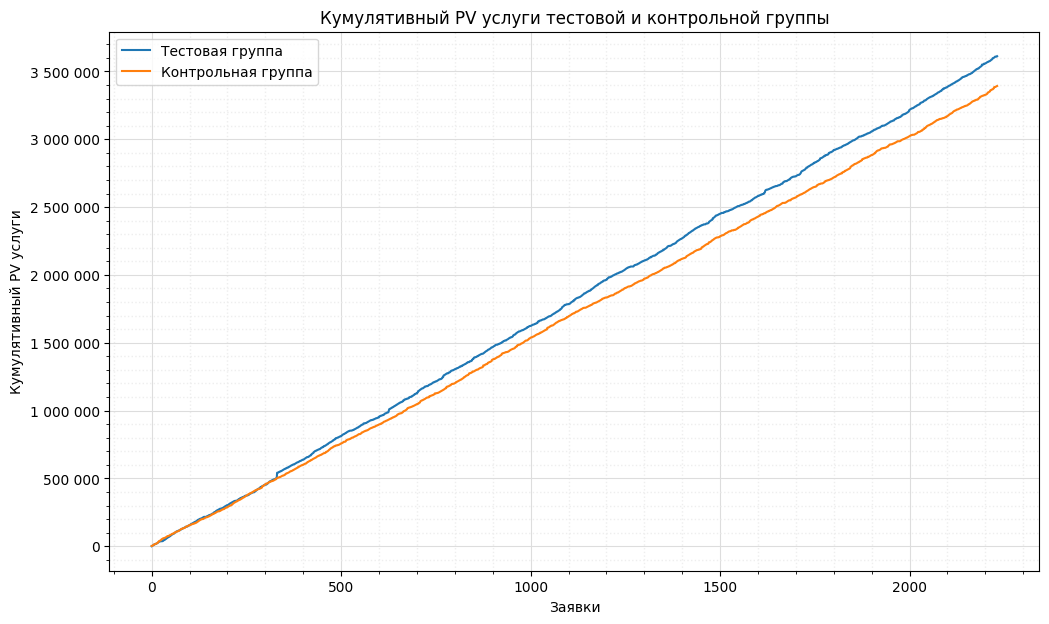

In [ ]:
cumulative_plot('cum_PV',
                'Кумулятивный PV услуги')

Как мы видим, тестовая группа продемонстрировала более высокий уровень кумулятивного PV услуги начиная с середины теста, что могло бы косвенно указывать на значимые различия в группах.

Рассмотрим график кумулятивного среднего PV услуги, которую мы также выбрали в качестве прокси метрики.

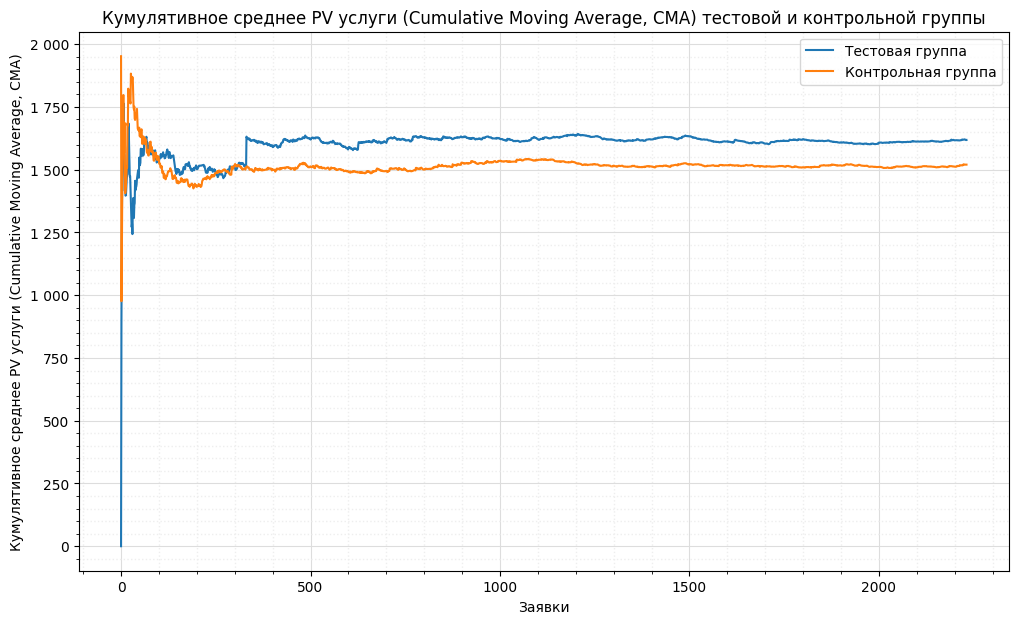

In [ ]:
cumulative_plot('cum_average_PV',
                'Кумулятивное среднее PV услуги (Cumulative Moving Average, CMA)')

Как мы видим, тестовая группа также продемонстрировала более высокий уровень кумулятивного среднего PV услуги на протяжении большей части теста.

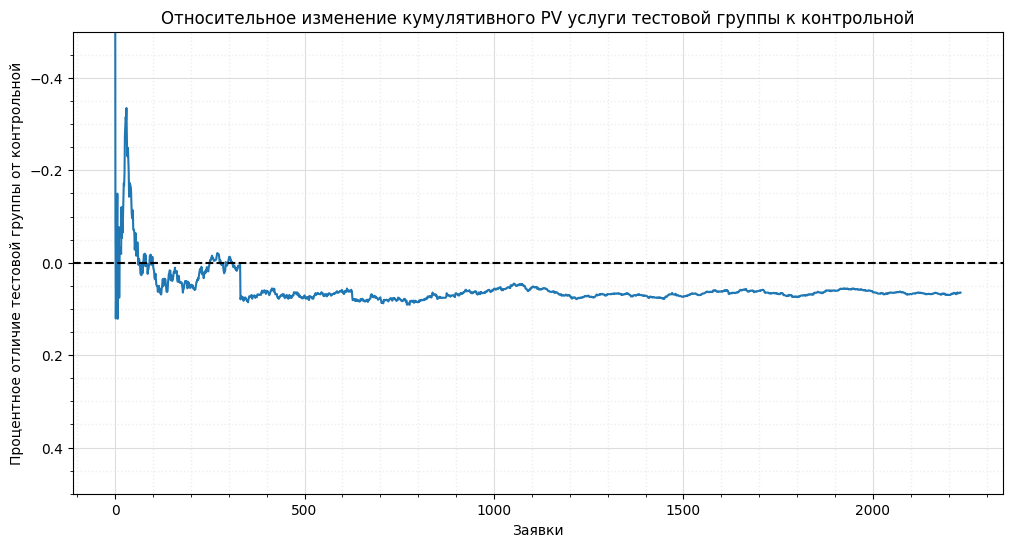

In [ ]:
relative_plot('cum_PV_test', 
              'cum_PV_control', 
              'Относительное изменение кумулятивного PV услуги тестовой группы к контрольной',
              0.5, -0.5)

На протяжении большей части тестирования значения кумулятивного PV услуги тестовой группы были меньше в среднем на 0.05%, чем у контрольной группы.

Рассмотрим график кумулятивной конверсии, которую мы выбрали в качестве контрольной метрики.

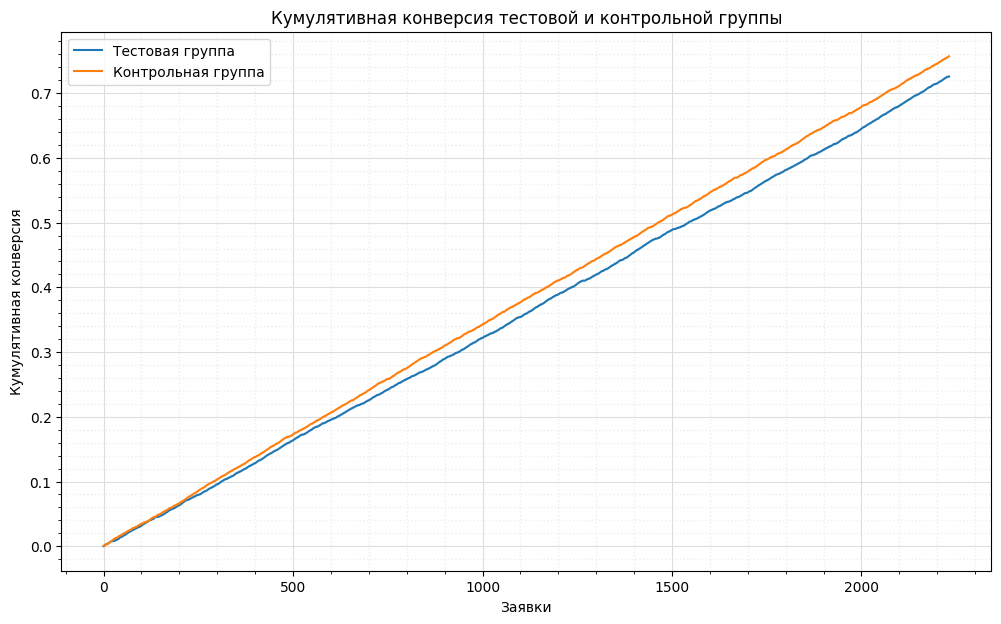

In [ ]:
cumulative_plot('cum_conversion', 
                'Кумулятивная конверсия', 
                ticks_format=False)

Мы видим, что на протяжении подавляющей части тестирования кумулятивная конверсия тестовой группы была значительно ниже, чем у контрольной группы.

Рассмотрим динамику относительного изменения кумулятивной конверсии тестовой группы к контрольной.

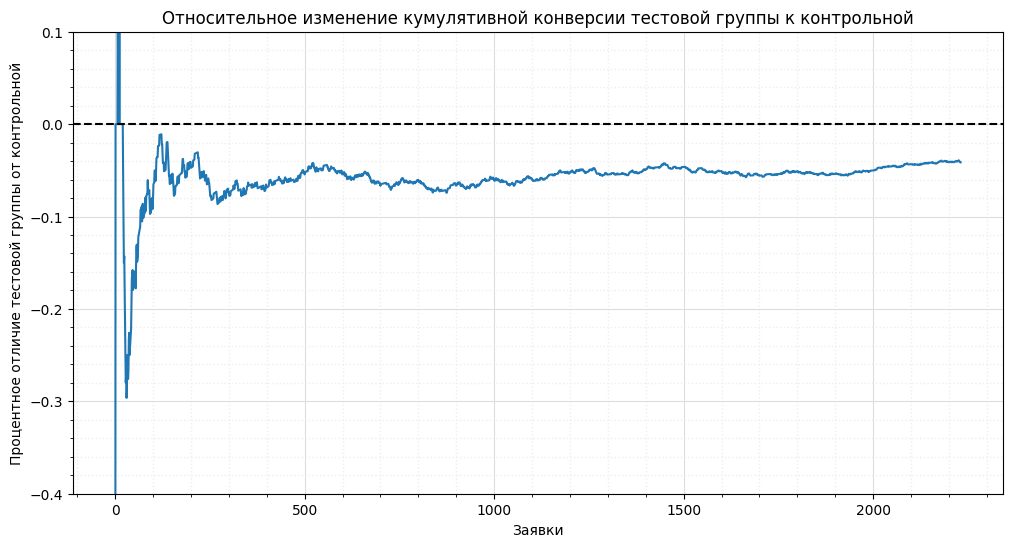

In [ ]:
relative_plot('cum_conversion_test', 
              'cum_conversion_control', 
              'Относительное изменение кумулятивной конверсии тестовой группы к контрольной',
              -0.40, 0.10)

Здесь мы также можем заметить, что подавляющую часть тестирования кумулятивная конверсия тестовой группы была ниже в среднем на 0.06%, чем у контрольной группы. Тестирование завершилось с отставанием тестовой группы от контрольной на 0.04%.

## Проверка параметра на однородность <a class='anchor' id='step_2_7'></a>

Рассмотрим распределения выборок.

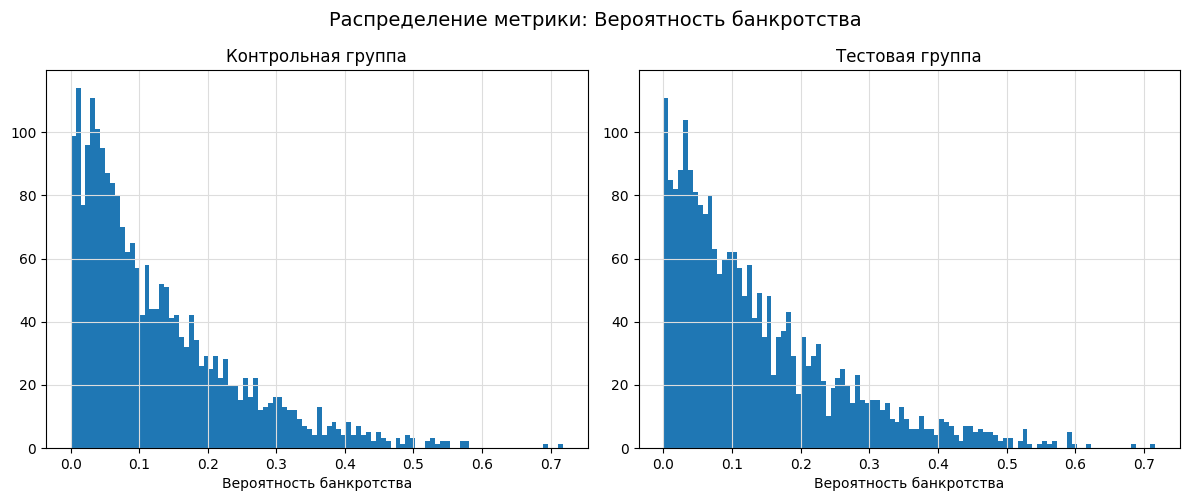

In [ ]:
dist_plot('Вероятность банкротства')

Визуально выборки имеют схожее распределение. Чтобы проверить их однородность, воспользуемся критерием Смирнова-Колмогорова.

<p>Для проверки однородности между выборками групп введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Распределение параметра (вероятность банкротства) в тестовой и контрольной группах не различается}\\
   H_1 :\text{Распределение параметра (вероятность банкротства) в тестовой и контрольной группах различается}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.02$

In [ ]:
p_value = ks_2samp(test['Вероятность банкротства'], control['Вероятность банкротства']).pvalue

print('p-value: ', '{:.4}'.format(p_value))

if p_value < 0.02:
    print('Отвергаем нулевую гипотезу: выборки из разных распределений')
else:
    print('Не получилось отвергнуть нулевую гипотезу, выборки имеют одинаковое распределение')

p-value:  0.02476
Не получилось отвергнуть нулевую гипотезу, выборки имеют одинаковое распределение


Полученное p-value составляет 0.02476, что больше уровня значимости 0.02. У нас нет оснований, чтобы отклонить нулевую гипотезу об однородности выборок в пользу альтернативной. Соответственно, выборки имеют схожее распределение.

## Применение критерия <a class='anchor' id='step_2_8'></a>

Далее, необходимо установить, имеют ли обнаруженные различия в метриках статистическую значимость. Прежде чем выбрать для этого статистический критерий, посмотрим на распределения целевой метрики PV услуги.

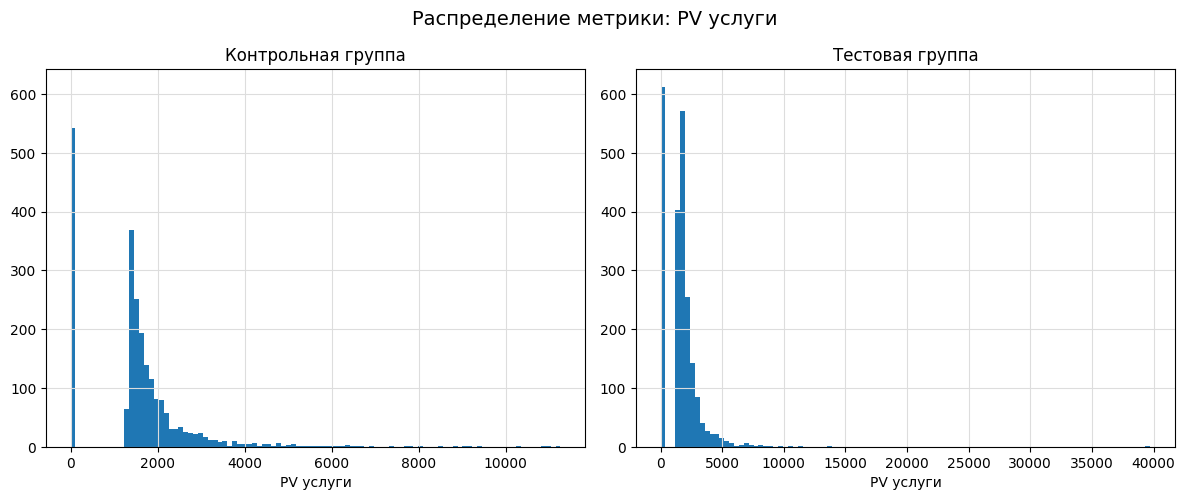

In [ ]:
dist_plot('PV услуги')

Распределения выборок не похожи на нормальное распределение. В тестовой группе заметен более длинный "хвост" максимальных значений, что косвенно указывает на наличие видимых различий.

Воспользуемся критерием Стьюдента для сравнения различий между PV услуги тестовой и контрольной группы.

<p>Для проверки статистически значимых различий между PV услуги групп (целевая метрика) введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Среднее значение PV услуги в тестовой и контрольной группах не различается}\\
   H_1 :\text{Среднее значение PV услуги в тестовой группе больше, чем среднее значение PV услуги в контрольной группе}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [ ]:
stat, p_value = ttest_ind(test['PV услуги'], control['PV услуги'], alternative='greater')

print('Процентное различие между средними выборок:',
    '{0:.3f}'.format(
    test['PV услуги'].mean()/control['PV услуги'].mean()-1))

print('p-value: ', '{:.4}'.format(p_value))

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными')

Процентное различие между средними выборок: 0.065
p-value:  0.01076
Отвергаем нулевую гипотезу: между выборками есть значимая разница


Между средними выборок наблюдается различие в размере 6.5%, которое имеет статистическую значимость. Полученное p-value составляет 0.01076, что меньше уровня значимости 0.05. У нас есть основания, чтобы отклонить нулевую гипотезу в пользу альтернативной. Процентное различие между средними выборок в размере 6.5% получено неслучайно с вероятностью 99.98924%.

Таким образом, в процессе проверки гипотез:

- была установлена однородность выборок;
- были обнаружены статистически значимые различия в целевой метрике групп.

По итогам тестирования, следует признать эксперимент успешным - тестовая группа показала статистически значимые отличия от контрольной группы.

[Назад к содержанию](#table_of_contents)